# Malaria Detection

This notebook is designed to create a model that predicts whether a cell is infected with malaria or not. The dataset used is the [Malaria Cell Images Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) from Kaggle. The dataset contains 27,558 cell images with equal instances of parasitized and uninfected cells. The images are of different sizes.

In [2]:
# Import libraries and set up source directories
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from random import randint
from skimage.transform import resize
from skimage import io, img_as_float, color
import seaborn as sns
import concurrent.futures
import gc

root = "../data"
labels = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
datapath = []
for label in labels:
    datapath.append(os.path.join(root, label))
datapath

['../data/Uninfected', '../data/Parasitized']

## Introduction

We have 2 classes of images: Uninfected and Parasitized. We will use the following encoding for them:

- 0 for Uninfected
- 1 for Parasitized

> Utility Section


In [3]:
def load_image(path):
    """Wrapper function for skimage.io.imread parallelization
    The image is returned as a numpy array with shape (M, N, 3) and dtype uint8."""
    return io.imread(path, pilmode="RGB")


def load_image_bw(path):
    """Wrapper function for skimage.io.imread parallelization
    The image is returned as a numpy array with shape (M, N) and dtype uint8."""
    return io.imread(path, pilmode="L")

In [4]:
"""Load the images in parallel using concurrent.futures and store them in different lists both in color and in black and white."""
# We use concurrent.futures to speed up the process, since it is a CPU-bound task
uninf_path = [os.path.join(datapath[0], _) for _ in os.listdir(datapath[0])]
para_path = [os.path.join(datapath[1], _) for _ in os.listdir(datapath[1])]
with concurrent.futures.ProcessPoolExecutor() as executor:
    uninf_imgs = executor.map(load_image, uninf_path)
    para_imgs = executor.map(load_image, para_path)
# convert the map object to a list
uninf_imgs = list(uninf_imgs)
para_imgs = list(para_imgs)
with concurrent.futures.ProcessPoolExecutor() as executor:
    uninf_imgs_bw = executor.map(load_image_bw, uninf_path)
    para_imgs_bw = executor.map(load_image_bw, para_path)
uninf_imgs_bw = list(uninf_imgs_bw)
para_imgs_bw = list(para_imgs_bw)


In [5]:
# store rgb channels in separate lists for later use
r_u_list = [img[:, :, 0] for img in uninf_imgs]
g_u_list = [img[:, :, 1] for img in uninf_imgs]
b_u_list = [img[:, :, 2] for img in uninf_imgs]
r_p_list = [img[:, :, 0] for img in para_imgs]
g_p_list = [img[:, :, 1] for img in para_imgs]
b_p_list = [img[:, :, 2] for img in para_imgs]

> Display sample images

We want to see some images to get a feel for the data and to make sure that the data is loaded correctly. We also want to see if there is something detectable by simply looking at the images before we start training a model.

_Using images as dataset means that we have one variable per pixel, and each image is a point in a very high-dimensional space. Single variable distributions and pairwise correlations are completely meaningless and unmanageable._


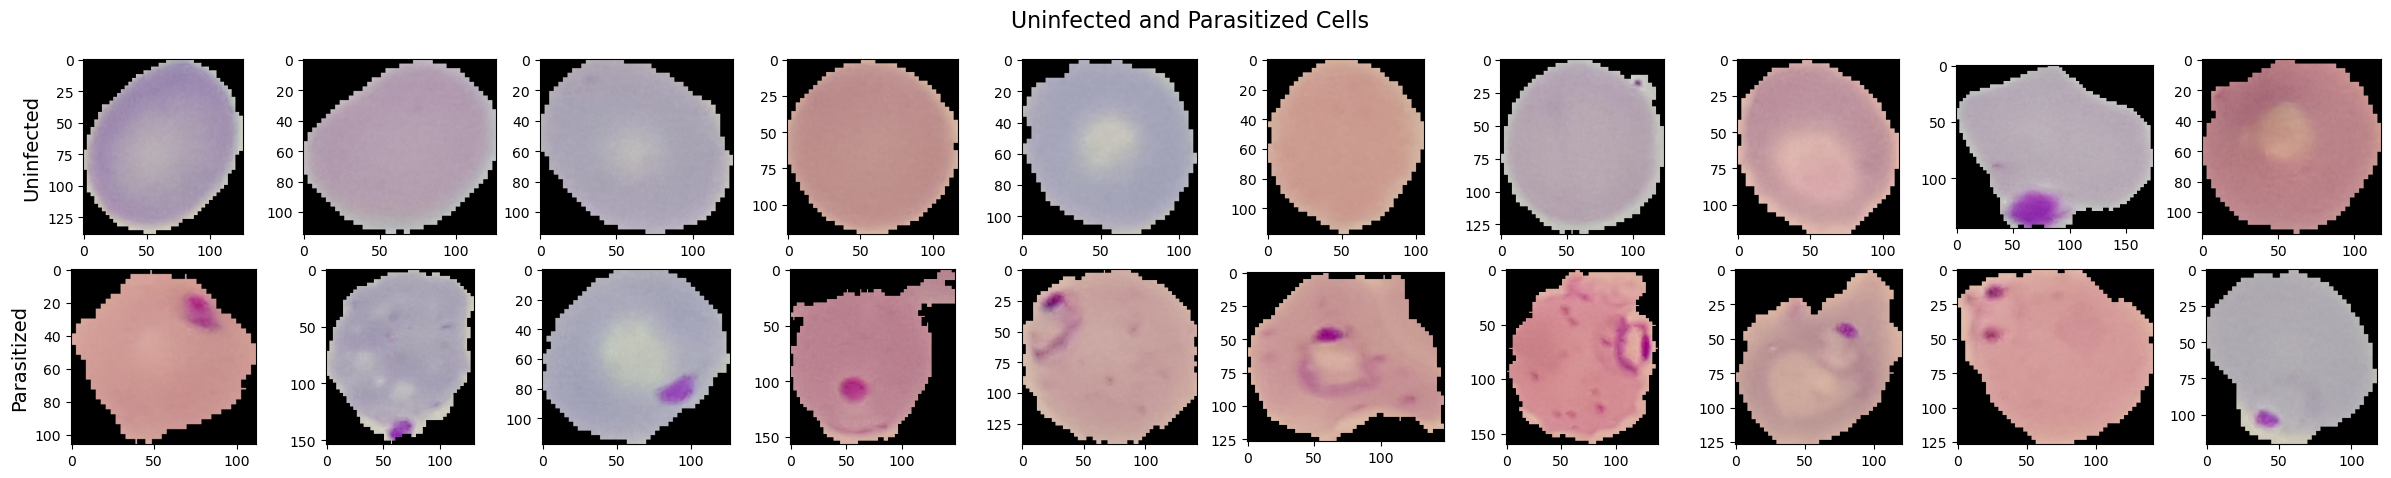

In [6]:
# select 10 random integers - we will use them to select images along this initial process
uninf_index = [randint(0, len(os.listdir(datapath[0]))) for _ in range(10)]
para_index = [randint(0, len(os.listdir(datapath[1]))) for _ in range(10)]
# plot the images
fig, ax = plt.subplots(2, 10, figsize=(30, 5))
fig.suptitle("Uninfected and Parasitized Cells", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs[uninf_index[i]])
    ax[1, i].imshow(para_imgs[para_index[i]])
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()

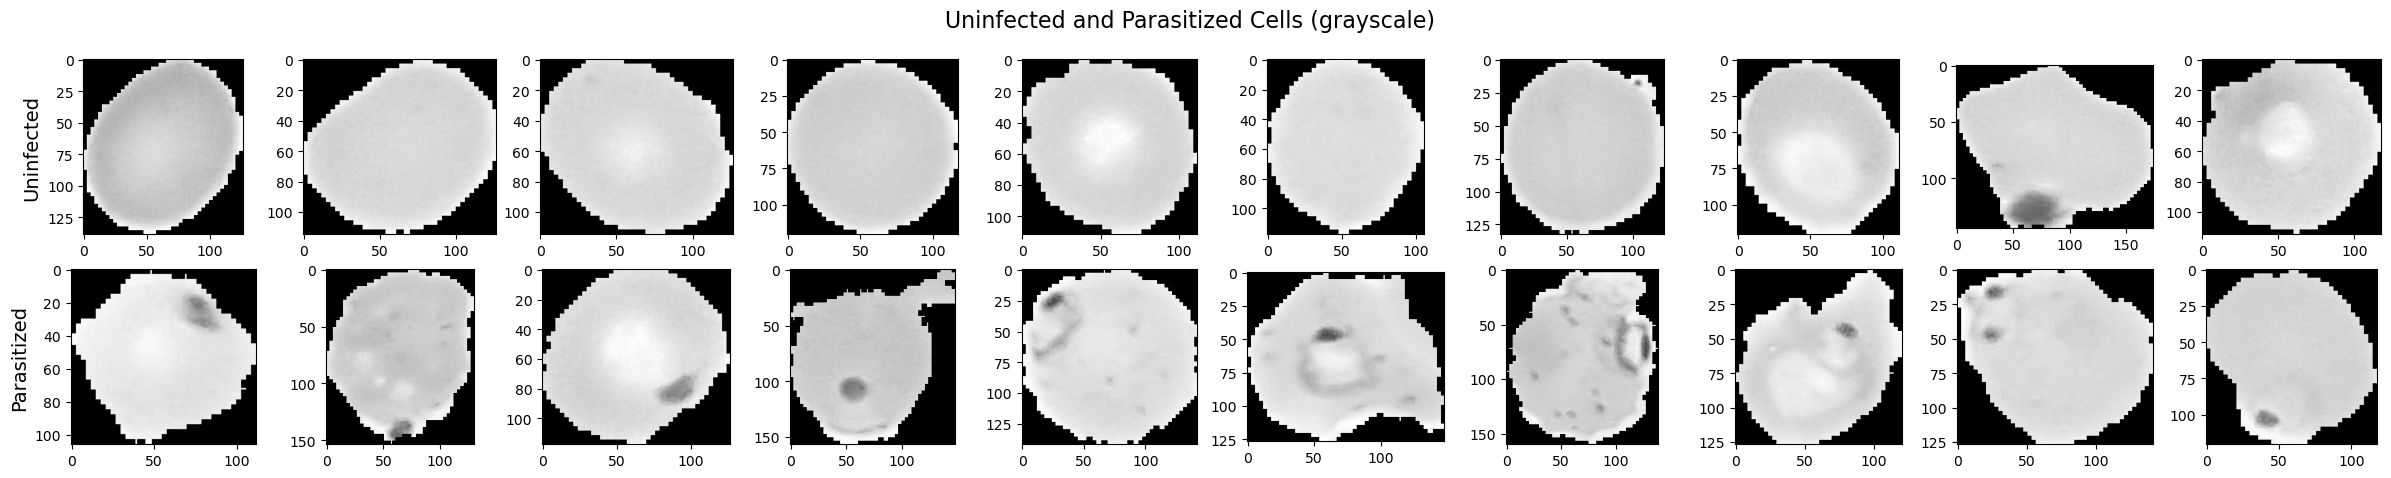

In [7]:
# plot the same images but in grayscale
fig, ax = plt.subplots(2, 10, figsize=(30, 5))
fig.suptitle("Uninfected and Parasitized Cells (grayscale)", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs_bw[uninf_index[i]], cmap="gray")
    ax[1, i].imshow(para_imgs_bw[para_index[i]], cmap="gray")
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()


## Dataset summary

Inspecting the images we can see that:

- Cells are of different shapes and sizes and that the infected cells have some visible violet spots.
- The morphology of the cells is not uniform and the violet spots are not always in the same place.
- The black borders presents in some images are not relevant and should be removed to avoid noise.
- Due to the fact that the color of the cells is not uniform, the violet spots could be more or less visible depending on the background color of the cell. Maybe the grayscale images will be more useful for the model.
- From the grayscale images we can see that the violet spots are darker than the rest of the cell and that the uninfected cells are lighter. This could be useful for the model, maybe with some preprocessing we can make the darker spots more visible.

We will use the grayscale images in the following steps, but we will keep the RGB images for future use.

> Create data structures that will hold the images and their labels

We are going to preprocess the images in order to make them more suitable for the model. Using the grayscale images we will:

1. Remove black borders.
2. Resize the images to standardize the size.
3. (next) Standardize the images using sklearn.preprocessing scalers. We will cross-validate the best scaler for our model.

**Note:** This process is also useful to reduce computation time when training the model.


In [8]:
"""
    Preprocessing functions to transform an image to be used in the model.
    We will use other functions later like sklearn scalers.
"""


def remove_background(image):
    """Remove the black background of the image. The function takes the image and the threshold value. If the pixel is below the threshold, it is set to 0.
    Args:
        image (np.ndarray): image to be processed loaded with skimage.io.imread
    """
    return np.where(image == 0.0, np.max(image), image)


def make_dataset(image, size=48):
    """Preprocessing function to transform an image to be used in the model. The steps are:
    1. Remove the black background
    2. Resize the image to the desired size
    We remove the black background before resizing the image to avoid having black borders in the resized image due to the interpolation maked by the resize function.
    The image is then flattened to be used in the model.
    Args:
        image (np.ndarray): image to be processed loaded with skimage.io.imread
        size (int): desired size of the image, the image will be resized to (size, size)
    """
    img = remove_background(image)
    img = resize(img, (size, size), anti_aliasing=True)
    return np.asarray(img).flatten()

In [9]:
# make a first preprocessing step to remove the black background and resize the images so that they have the same size and can be used as input for the model
with concurrent.futures.ProcessPoolExecutor() as executor:
    u = np.asarray(list(executor.map(make_dataset, uninf_imgs_bw)))
    p = np.asarray(list(executor.map(make_dataset, para_imgs_bw)))
del (
    datapath,
    label,
    labels,
    uninf_path,
    para_path,
    uninf_imgs,
    para_imgs,
    uninf_imgs_bw,
    para_imgs_bw,
    ax,
    fig,
    i,
    executor,
)
gc.collect()
# create matrix of features from the numpy vectors
X = np.concatenate((u, p))
# create matrix of labels from the numpy vectors length
y = np.concatenate((np.zeros(len(u)), np.ones(len(p)))).reshape(-1, 1)
# pandas dataframe
df = pd.DataFrame(data=X, columns=range(np.shape(X)[1])).merge(
    pd.DataFrame(data=y, columns=["labels"]), left_index=True, right_index=True
)
# df.head()

In [10]:
# store the dataframe in a csv file
# df.to_csv(os.path.join(root,"data.csv"), index=False)


Simple check on the distribution of the labels in the training and test sets. This will lead to see that our dataset is balanced.


Is the dataset balanced?  Yes


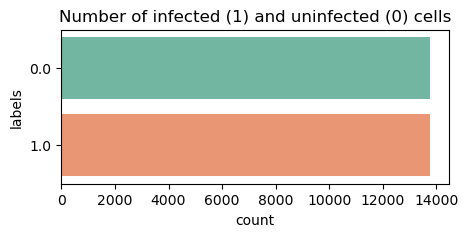

In [11]:
# Count the number of uninfected and infected cells
plt.figure(figsize=(5, 2), dpi=100)
plt.title("Number of infected (1) and uninfected (0) cells")
sns.countplot(y=df["labels"], palette="Set2")
print(
    "Is the dataset balanced? ",
    "Yes" if df["labels"].value_counts()[0] == df["labels"].value_counts()[1] else "No",
)


> Split the dataset into Training and Test sets

- Training set: 70% of the dataset -> we will use this set to train the model after data augmentation
- Test set: 30% of the dataset -> we will use this set to test the model

_During the training phase we will use K-Fold Cross Validation to evaluate the model and tune its hyperparameters._


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training validation and test sets
test_ratio = 0.3
# now make two splits:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df.drop(columns=["labels"]),
    df["labels"],
    test_size=test_ratio,
    shuffle=True,
    stratify=y,
    random_state=42,
)

## Understanding model complexity

Using images, our dataset has a lot of features, so we will try to understand if model reduction techniques can help us. We will use PCA to reduce the dimensionality because we have only 2 classes and a supervised model is not necessary.

If the explained variance is not enough to explain the data, we need to use a more complex model. Probably a neural network.

_About LDA: we don't use LDA as a dimensionality reduction method because with just 2 classes the output of the reduction will have only 1 dimension._

> PCA


Explained variance ratio: 0.90


0

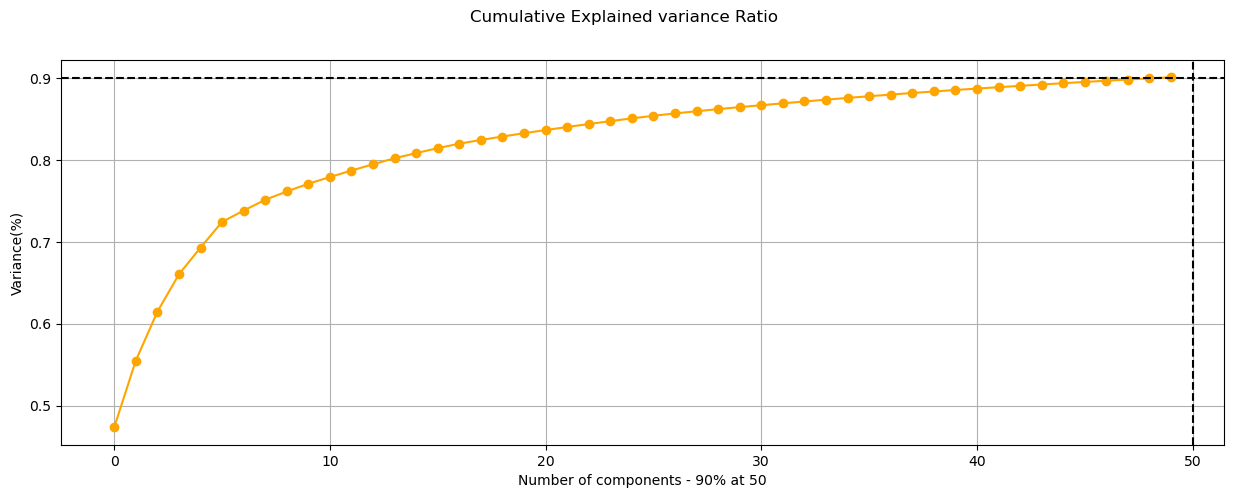

In [13]:
# Calculate the explained variance ratio to determine the number of components needed to explain 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(X_train_val)
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Cumulative Explained variance Ratio")
plt.xlabel(f"Number of components - 90% at {pca.components_.shape[0]}")
plt.ylabel("Variance(%)")
plt.plot(
    range(len(pca.explained_variance_ratio_)),
    pca.explained_variance_ratio_.cumsum(),
    "o-",
    color="orange",
)
plt.axhline(y=0.9, color="black", linestyle="--")
plt.axvline(x=pca.components_.shape[0], color="black", linestyle="--")
plt.grid()
print(f"Explained variance ratio: {pca.explained_variance_ratio_.cumsum()[-1]:.2f}")
del pca, fig
gc.collect()


**Analysis:** Using 50 components we can explain 90% of the variance, so we can use this number as a threshold to reduce the dimensionality of the dataset from 2304 to 50.

> Scaling the dataset

We will scale the dataset with two different techniques that produced better results during the analysis: StandardScaler and RobustScaler. The former will scale the data to have zero mean and unit variance, while the latter will set the mean to zero (and unit variance if enabled) according to the interquartile (25-75%) range.

_Note: the std scaler is designed to reduce the effect of outliers in the data. If our model will perform better with the std that means that outliers are present in the data._


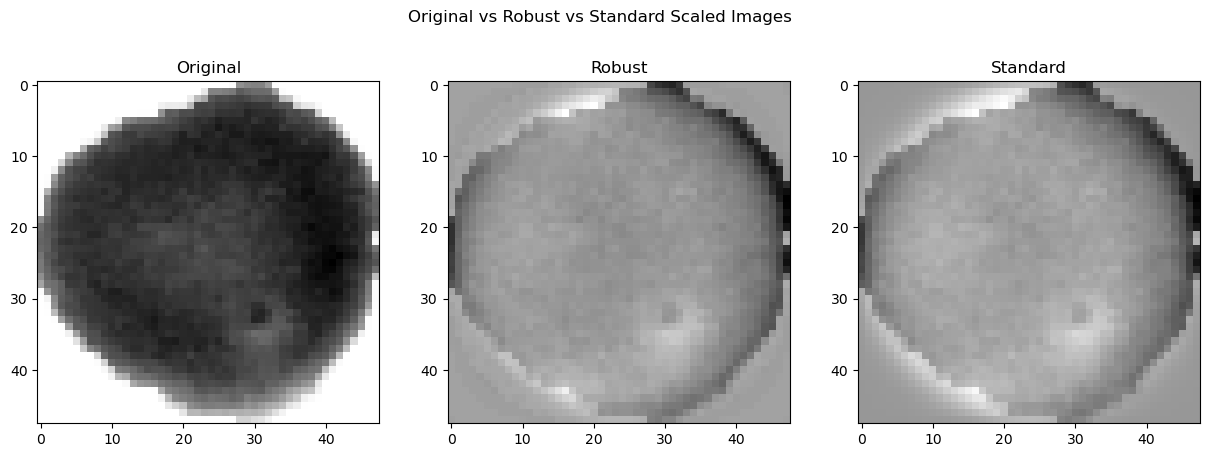

In [14]:
# Prepare the data for the model
from sklearn.preprocessing import StandardScaler, RobustScaler

# initialize the scalers
robust_scale = RobustScaler().fit(X_train_val)
std_scale = StandardScaler().fit(X_train_val)
# fit and transform the data
x_robust = robust_scale.transform(X_train_val)
x_std = std_scale.transform(X_train_val)
# plot samples of the original, robust and standard scaled images
plt.figure(figsize=(15, 5), dpi=100)
plt.suptitle("Original vs Robust vs Standard Scaled Images")
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(X_train_val.iloc[1500].values.reshape(48, 48), cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Robust")
plt.imshow(x_robust[1500].reshape(48, 48), cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Standard")
plt.imshow(x_std[1500].reshape(48, 48), cmap="gray")

# Classification tests

We will use simple models to test the dataset and to understand if we can get a good accuracy with a simple model. Then we will try to optimize the best scoring model searching for the best hyperparameters.

_Note: we will show Confusion Matrix, Precision-Recall, and ROC Curve for better combination of each model._


In [15]:
from sklearn.metrics import (
    RocCurveDisplay,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    precision_recall_curve,
    roc_curve,
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
)


def get_scores(model, X_train, y_train, X_test, y_test, display=False, name=None):
    """
    Function to calculate the accuracy, precision, recall and f1 score of a model.
    The confusion matrix is calculated and plotted if display is set to True. In this case, we can also see the accuracy of the model
    because we are in a binary classification problem. The order of values in the confusion matrix is: [TN, FP, FN, TP]
    Plot for the precision-recall curve and the ROC curve are also plotted if display is set to True.
        - High precision values indicate that the model is not labeling many samples as positive that are actually negative.
        - High recall values indicate that the model is labeling many samples as positive that are actually positive.
        - Higher is the area under the ROC curve, better is the separation between the two classes.
    Args:
        model (sklearn model): model to be evaluated. Must implement predict and score methods.
        X (np.ndarray): training data
        y (np.ndarray): training labels
        X_test (np.ndarray): test data
        y_test (np.ndarray): test labels
    """
    if display:
        assert name is not None, "You must provide a name for the plot"
    fitted = model.fit(X_train, y_train)
    y_pred = fitted.predict(X_test)
    y_proba = (
        fitted.predict_proba(X_test)
        if hasattr(fitted, "predict_proba")
        else fitted._final_estimator._predict_proba_lr(X_test)
    )
    y_score = (
        fitted.decision_function(X_test)
        if hasattr(fitted, "decision_function")
        else y_proba[:, 1]
    )
    cm = confusion_matrix(y_test, y_pred, labels=fitted.classes_, normalize="true")
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    auc = roc_auc_score(y_test, y_proba[:, 1])
    if display:
        fig, ax = plt.subplots(1, 3, figsize=(20, 5))
        fig.suptitle(
            f"Model: {name} - Accuracy: {acc.mean():.2f} - F1: {f1.mean():.2f} - Recall: {recall.mean():.2f} - Precision: {precision.mean():.2f} - TPR: {tpr.mean():.2f} - FPR: {fpr.mean():.2f}"
        )
        cm_display = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=fitted.classes_
        ).plot(ax=ax[0], colorbar=False)
        cm_display.ax_.set_title("Confusion Matrix (Normalized)")
        cm_display.ax_.set_ylabel("True label")
        cm_display.ax_.set_xlabel("Predicted label")
        pre_rec_display = PrecisionRecallDisplay(
            precision=precision, recall=recall
        ).plot(ax=ax[1])
        pre_rec_display.ax_.set_title("Precision-Recall Curve")
        pre_rec_display.ax_.set_ylabel("Precision")
        pre_rec_display.ax_.set_xlabel("Recall")
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[2])
        roc_display.ax_.set_title("ROC Curve - AUC: {:.3f}".format(auc))
        roc_display.ax_.set_ylabel(f"True Positive Rate")
        roc_display.ax_.set_xlabel(f"False Positive Rate")
    scores = classification_report(
        y_test, y_pred, labels=fitted.classes_, output_dict=True
    )
    keys = list(scores[str(float("0"))]) + ["AUC"]
    index = list(scores.keys()) + ["ROC"]
    df = pd.DataFrame(index=index, columns=keys)
    for k in list(index):
        if k == str(float("0")) or k == str(float("1")):
            df.loc[k] = list(scores[k].values()) + [np.NaN]
        elif k == "accuracy":
            df.loc[k] = [np.NaN, np.NaN, scores[k], X_test.shape[0]] + [np.NaN]
        elif k == "macro avg" or k == "weighted avg":
            df.loc[k] = list(scores[k].values()) + [np.NaN]
        else:
            df.loc[k] = [np.NaN, np.NaN, np.NaN, np.NaN, auc]
    return df, cm

In [16]:
"""Pipelines"""
# We will use pipelines to make the testing workflow easier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
)


In [73]:

# define the models - parameters are selected looking at the documentation and the results of some tests (no optimization was done at the moment)
sgdc = SGDClassifier(
    loss="modified_huber", penalty="elasticnet", max_iter=10000, n_jobs=-1
)
lsvc = LinearSVC(C=1e-4, dual=False, max_iter=10000)
lr = LogisticRegression(C=1e-4, n_jobs=-1, solver="saga", max_iter=10000, dual=False)
knc = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rfc = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=500,
    max_depth=40,
    min_samples_split=3,
    min_samples_leaf=6,
    criterion="entropy",
    bootstrap=True,
)
ada = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=0.1,
    estimator=DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=6, max_features="log2", ccp_alpha=0.001
    ),
)
hgb = HistGradientBoostingClassifier(
    learning_rate=0.05, max_iter=300, early_stopping=True
)
# define robust pipelines
robust_pipe_SGDC = make_pipeline(
    RobustScaler(), Nystroem(n_components=1000, n_jobs=-1), sgdc
)
robust_pipe_LSVC = make_pipeline(RobustScaler(), lsvc)
robust_pipe_LR = make_pipeline(RobustScaler(), lr)
robust_pipe_KNN = make_pipeline(RobustScaler(), knc)
robust_pipe_RF = make_pipeline(RobustScaler(), rfc)
robust_pipe_ADA = make_pipeline(RobustScaler(), ada)
robust_pipe_HGB = make_pipeline(RobustScaler(), hgb)
# define std pipelines
std_pipe_SGDC = make_pipeline(
    StandardScaler(), Nystroem(n_components=1000, n_jobs=-1), sgdc
)
std_pipe_LSVC = make_pipeline(StandardScaler(), lsvc)
std_pipe_LR = make_pipeline(StandardScaler(), lr)
std_pipe_KNN = make_pipeline(StandardScaler(), knc)
std_pipe_RF = make_pipeline(StandardScaler(), rfc)
std_pipe_ADA = make_pipeline(StandardScaler(), ada)
std_pipe_HGB = make_pipeline(StandardScaler(), hgb)
# define robust pipelines with PCA
r_pca_pipe_SGDC = make_pipeline(
    RobustScaler(), Nystroem(n_components=1000, n_jobs=-1), PCA(n_components=0.9), sgdc
)
r_pca_pipe_LSVC = make_pipeline(RobustScaler(), PCA(n_components=0.9), lsvc)
r_pca_pipe_LR = make_pipeline(RobustScaler(), PCA(n_components=0.9), lr)
r_pca_pipe_KNN = make_pipeline(RobustScaler(), PCA(n_components=0.9), knc)
r_pca_pipe_RF = make_pipeline(RobustScaler(), PCA(n_components=0.9), rfc)
r_pca_pipe_ADA = make_pipeline(RobustScaler(), PCA(n_components=0.9), ada)
r_pca_pipe_HGB = make_pipeline(RobustScaler(), PCA(n_components=0.9), hgb)
# define std pipelines with PCA
s_pca_pipe_SGDC = make_pipeline(
    StandardScaler(),
    Nystroem(n_components=1000, n_jobs=-1),
    PCA(n_components=0.9),
    sgdc,
)
s_pca_pipe_LSVC = make_pipeline(StandardScaler(), lsvc)
s_pca_pipe_LR = make_pipeline(StandardScaler(), PCA(n_components=0.9), lr)
s_pca_pipe_KNN = make_pipeline(StandardScaler(), PCA(n_components=0.9), knc)
s_pca_pipe_RF = make_pipeline(StandardScaler(), PCA(n_components=0.9), rfc)
s_pca_pipe_ADA = make_pipeline(StandardScaler(), PCA(n_components=0.9), ada)
s_pca_pipe_HGB = make_pipeline(StandardScaler(), PCA(n_components=0.9), hgb)

> Stochastic Gradient Descent
<a id='sgd_cell'></a>

Classifier that implements the Stoachastic Gradient Descent algorithm. [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

,precision,recall,f1-score,support,AUC
0.0,0.855482,0.872037,0.86368,4134,NaN
1.0,0.869512,0.852685,0.861016,4134,NaN
accuracy,NaN,NaN,0.862361,8268,NaN
macro avg,0.862497,0.862361,0.862348,8268,NaN
weighted avg,0.862497,0.862361,0.862348,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.922242


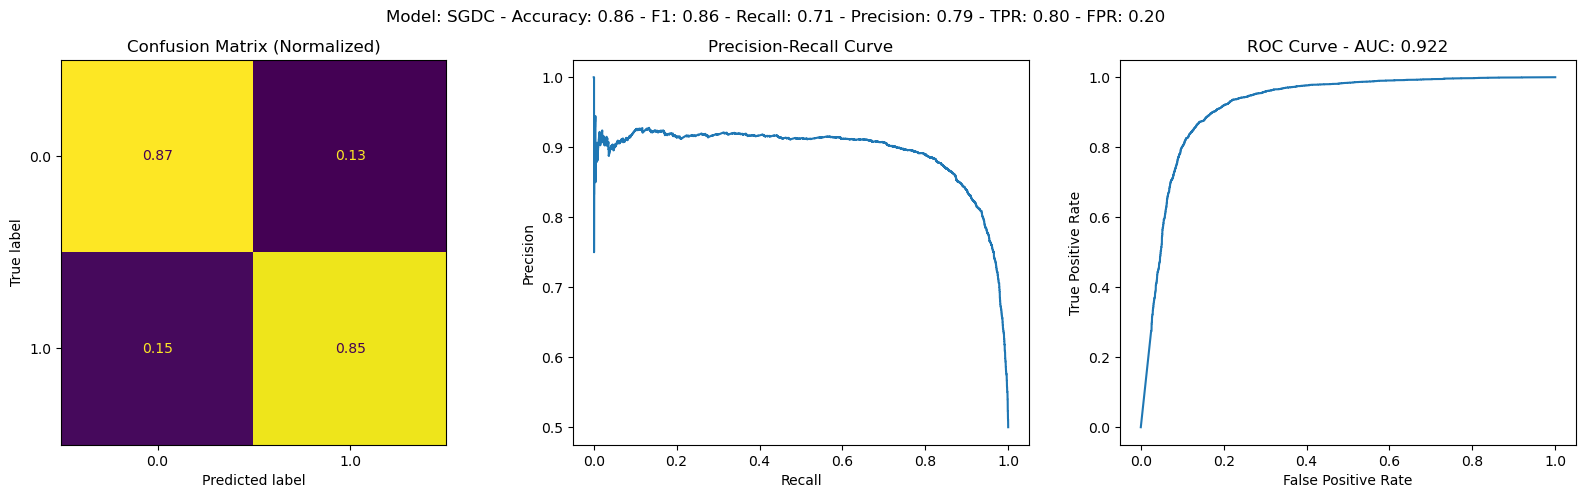

In [18]:
r_score_sgd, r_cm_sgd = get_scores(
    robust_pipe_SGDC,
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    display=True,
    name="SGDC",
)
r_score_sgd

In [19]:
# rp_score_sgd, rp_cm_sgd = get_scores(r_pca_pipe_SGDC, X_train_val, y_train_val, X_test, y_test)
# rp_score_sgd

In [20]:
# s_score_sgd, s_cm_sgd = get_scores(std_pipe_SGDC, X_train_val, y_train_val, X_test, y_test)
# s_score_sgd

In [21]:
# sp_score_sgd, sp_cm_sgd = get_scores(s_pca_pipe_SGDC, X_train_val, y_train_val, X_test, y_test)
# sp_score_sgd

> Linear Support Vector Classification

Supervised learning model for classification. It's an optimized implementation of the Support Vector Machine algorithm for the case of a linear kernel. It is useful in high dimensional spaces like images.


In [22]:
# r_score_lsvc, r_cm_lsvc = get_scores(robust_pipe_LSVC, X_train_val, y_train_val, X_test, y_test)
# r_score_lsvc

In [23]:
# rp_score_lsvc, rp_cm_lsvc = get_scores(r_pca_pipe_LSVC, X_train_val, y_train_val, X_test, y_test)
# rp_score_lsvc

,precision,recall,f1-score,support,AUC
0.0,0.661595,0.746734,0.701591,4134,NaN
1.0,0.709328,0.618045,0.660548,4134,NaN
accuracy,NaN,NaN,0.68239,8268,NaN
macro avg,0.685461,0.68239,0.681069,8268,NaN
weighted avg,0.685461,0.68239,0.681069,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.729092


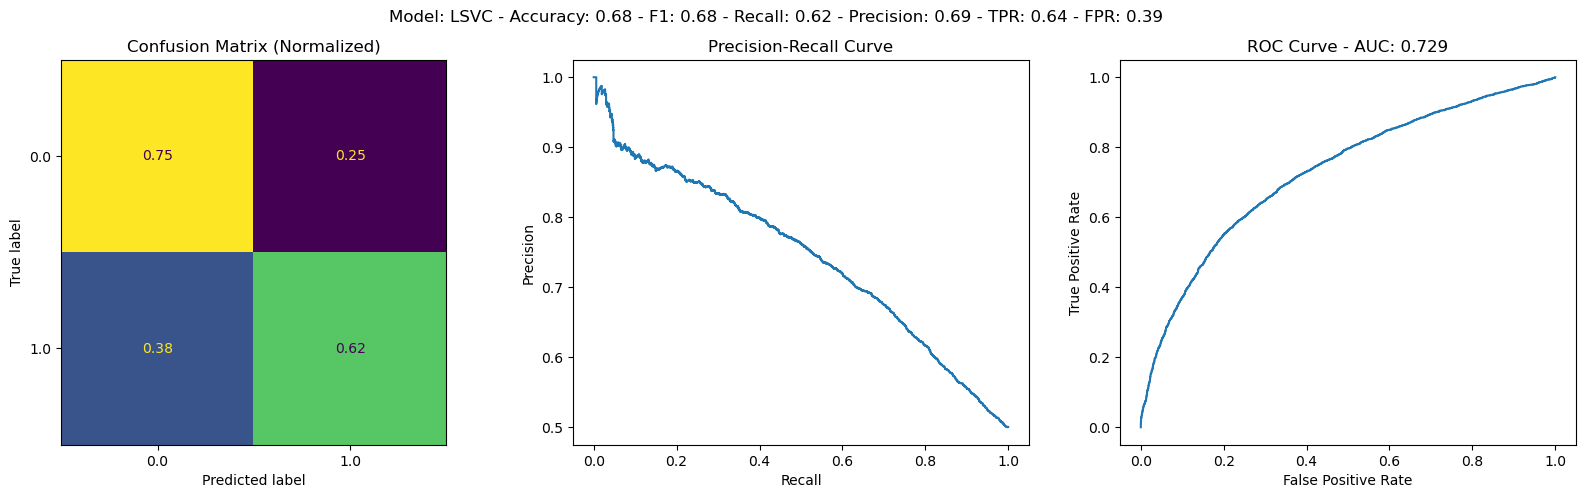

In [24]:
s_score_lsvc, s_cm_lsvc = get_scores(
    std_pipe_LSVC, X_train_val, y_train_val, X_test, y_test, display=True, name="LSVC"
)
s_score_lsvc

In [25]:
# sp_score_lsvc, sp_cm_lsvc = get_scores(s_pca_pipe_LSVC, X_train_val, y_train_val, X_test, y_test)
# sp_score_lsvc

> Logistic Regression

Supervised learning algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. It is a special case of linear regression where the dependent variable is categorical in nature. It is used to estimate the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick.


In [26]:
# r_score_lr, r_cm_lr = get_scores(robust_pipe_LR, X_train_val, y_train_val, X_test, y_test)
# r_score_lr

In [27]:
# rp_score_lr, rp_cm_lr = get_scores(r_pca_pipe_LR, X_train_val, y_train_val, X_test, y_test)
# rp_score_lr

,precision,recall,f1-score,support,AUC
0.0,0.665997,0.722061,0.692897,4134,NaN
1.0,0.696513,0.637881,0.665909,4134,NaN
accuracy,NaN,NaN,0.679971,8268,NaN
macro avg,0.681255,0.679971,0.679403,8268,NaN
weighted avg,0.681255,0.679971,0.679403,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.733812


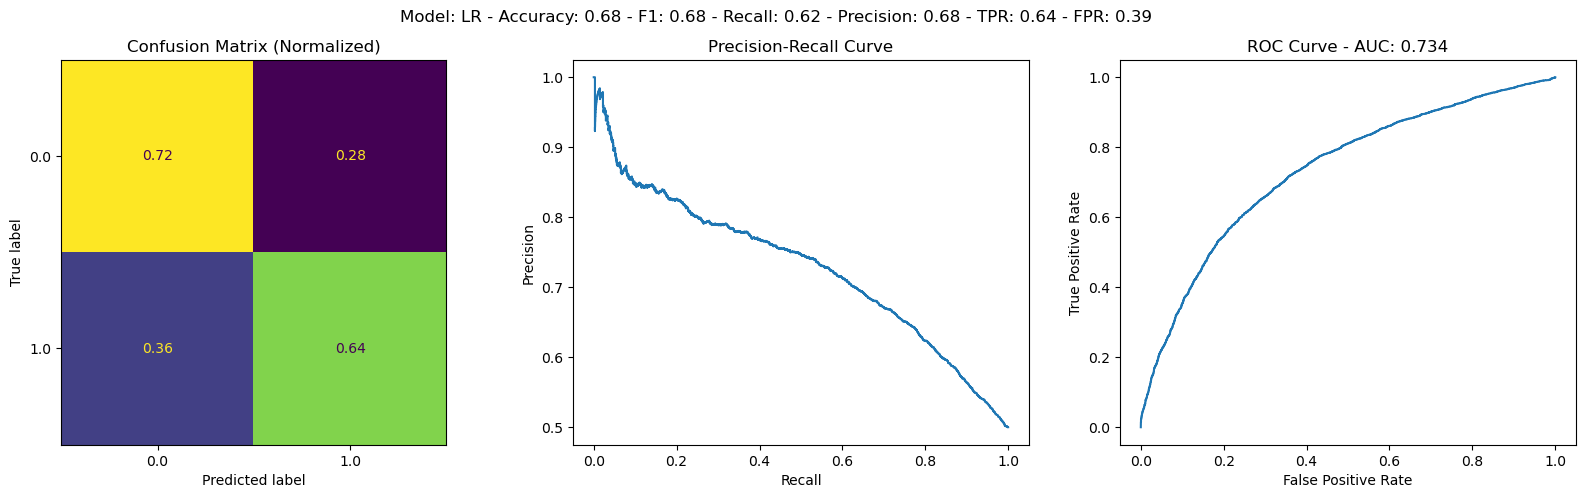

In [28]:
s_score_lr, s_cm_lr = get_scores(
    std_pipe_LR, X_train_val, y_train_val, X_test, y_test, display=True, name="LR"
)
s_score_lr

In [29]:
# sp_score_lr, sp_cm_lr = get_scores(s_pca_pipe_LR, X_train_val, y_train_val, X_test, y_test)
# sp_score_lr

> K-Nearest Neighbors

Supervised learning algorithm based on the k-nearest neighbors principle. it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.


In [30]:
# r_score_knn, r_cm_knn = get_scores(robust_pipe_KNN, X_train_val, y_train_val, X_test, y_test)
# r_score_knn

,precision,recall,f1-score,support,AUC
0.0,0.587528,0.945815,0.724812,4134,NaN
1.0,0.861128,0.335994,0.483383,4134,NaN
accuracy,NaN,NaN,0.640905,8268,NaN
macro avg,0.724328,0.640905,0.604097,8268,NaN
weighted avg,0.724328,0.640905,0.604097,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.737624


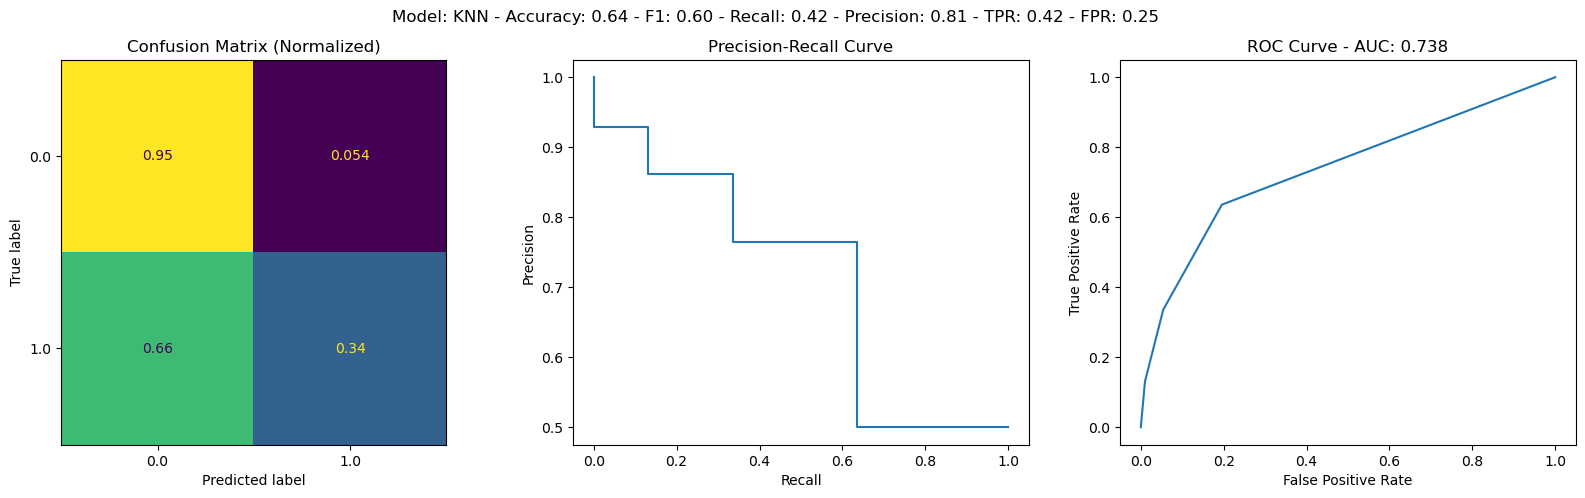

In [31]:
rp_score_knn, rp_cm_knn = get_scores(
    r_pca_pipe_KNN, X_train_val, y_train_val, X_test, y_test, display=True, name="KNN"
)
rp_score_knn

In [32]:
# s_score_knn, s_cm_knn = get_scores(std_pipe_KNN, X_train_val, y_train_val, X_test, y_test)
# s_score_knn

In [33]:
# sp_score_knn, sp_cm_knn = get_scores(s_pca_pipe_KNN, X_train_val, y_train_val, X_test, y_test)
# sp_score_knn

> Random Forest

Tree-based model that uses a number of decision trees to predict the outcome of a data point with the purpose of reducing the error rate of the model trading off variance for bias to reduce the overfitting.


In [34]:
# r_score_rf, r_cm_rf = get_scores(robust_pipe_RF, X_train_val, y_train_val, X_test, y_test)
# r_score_rf

In [35]:
# rp_score_rf, rp_cm_rf = get_scores(r_pca_pipe_RF, X_train_val, y_train_val, X_test, y_test)
# rp_score_rf

In [36]:
# s_score_rf, s_cm_rf = get_scores(std_pipe_RF, X_train_val, y_train_val, X_test, y_test)
# s_score_rf

,precision,recall,f1-score,support,AUC
0.0,0.920879,0.810837,0.862362,4134,NaN
1.0,0.831029,0.930334,0.877882,4134,NaN
accuracy,NaN,NaN,0.870585,8268,NaN
macro avg,0.875954,0.870585,0.870122,8268,NaN
weighted avg,0.875954,0.870585,0.870122,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.943179


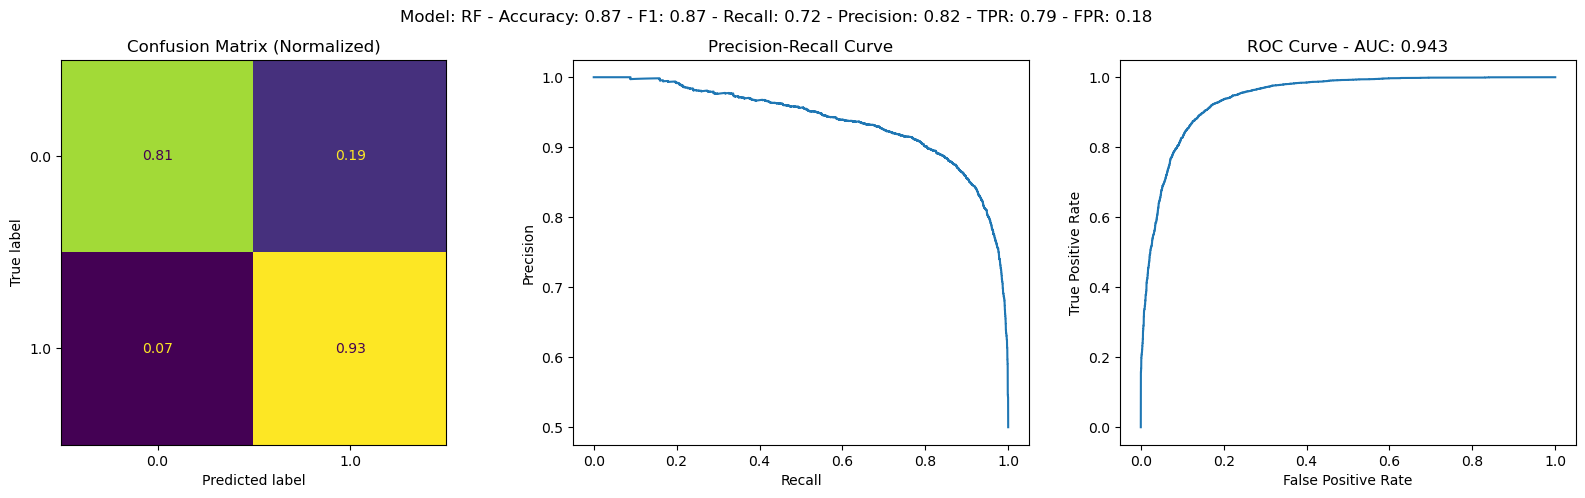

In [37]:
sp_score_rf, sp_cm_rf = get_scores(
    s_pca_pipe_RF, X_train_val, y_train_val, X_test, y_test, display=True, name="RF"
)
sp_score_rf

> AdaBoost

Model that fit a sequence of weak learners (models that are slightly better than random guessing) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.


In [38]:
# r_score_ada, r_cm_ada= get_scores(robust_pipe_ADA, X_train_val, y_train_val, X_test, y_test)
# r_score_ada

,precision,recall,f1-score,support,AUC
0.0,0.8839,0.861877,0.87275,4134,NaN
1.0,0.865235,0.886792,0.875881,4134,NaN
accuracy,NaN,NaN,0.874335,8268,NaN
macro avg,0.874567,0.874335,0.874315,8268,NaN
weighted avg,0.874567,0.874335,0.874315,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.94159


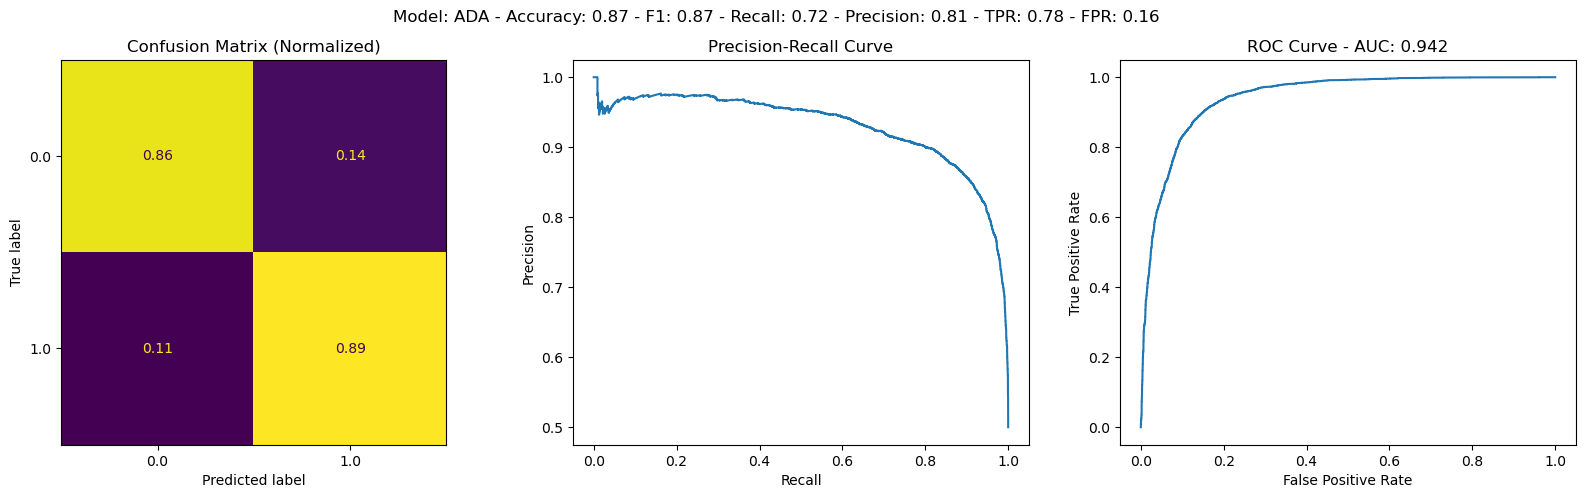

In [39]:
rp_score_ada, rp_cm_ada = get_scores(
    r_pca_pipe_ADA, X_train_val, y_train_val, X_test, y_test, display=True, name="ADA"
)
rp_score_ada

In [40]:
# s_score_ada, s_cm_ada= get_scores(std_pipe_ADA, X_train_val, y_train_val, X_test, y_test)
# s_score_ada

In [41]:
# sp_score_ada, sp_cm_ada= get_scores(s_pca_pipe_ADA, X_train_val, y_train_val, X_test, y_test)
# sp_score_ada

> Hist Gradient (tree) Boosting

Optimized implementation of gradient boosting decision trees. This estimators first bin the input samples into integer-valued bins, reducing the number of splits to build the trees. The speed-up cames from the fact that the algorithm uses integer-based data structures to represent the binned data, which is faster than using the original floating-point values.


,precision,recall,f1-score,support,AUC
0.0,0.891103,0.952104,0.920594,4134,NaN
1.0,0.948585,0.883648,0.914966,4134,NaN
accuracy,NaN,NaN,0.917876,8268,NaN
macro avg,0.919844,0.917876,0.91778,8268,NaN
weighted avg,0.919844,0.917876,0.91778,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.970824


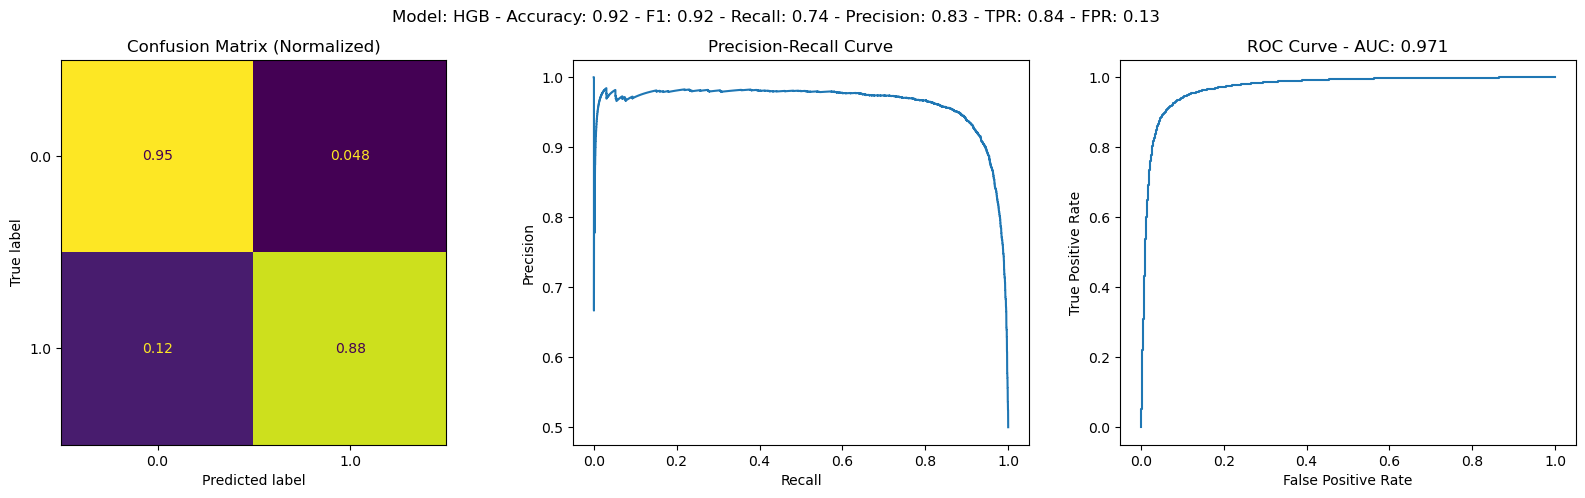

In [42]:
r_score_hgb, r_cm_hgb = get_scores(
    robust_pipe_HGB, X_train_val, y_train_val, X_test, y_test, display=True, name="HGB"
)
r_score_hgb

In [43]:
# rp_score_hgb, rp_cm_hgb = get_scores(r_pca_pipe_HGB, X_train_val, y_train_val, X_test, y_test)
# rp_score_hgb

In [44]:
# s_score_hgb, s_cm_hgb = get_scores(std_pipe_HGB, X_train_val, y_train_val, X_test, y_test)
# s_score_hgb

In [45]:
# sp_score_hgb, sp_cm_hgb = get_scores(s_pca_pipe_HGB, X_train_val, y_train_val, X_test, y_test)
# sp_score_hgb

Looking at the _f1-score accuracy_ of these models we can see that:

1. Linear Support Vector Machine and Logistic Regression have similar accuracy but bad performance. Probably because using images we can't get a good estimate of the probability distribution of the data.
2. KNN has bad performance, but it will increase with the use of PCA.
3. Generally speaking, Ensemble Methods performed very well and PCA increased the accuracy of the models and reduced the training time.
4. Stochastic Gradient Descent performed very well with the RobustScaler and it's ROC-AUC is similar to the ensemble methods but with better training time due to the kernel approximation (**Needed for a correct execution of the algorithm as described in the documentation**).
5. The only exception for the _3rd_ point is the Histogram based Gradient Boosting classifier that performed very well without PCA and it's the better one when combined with the RobustScaler.

Looking at the _ROC Curve_ we can see that a lot of models have a good performance, but the best one is the Histogram based Gradient Boosting classifier. It has a good _AUC_ and a good _Precision-Recall_ curve.

We will use the Histogram based Gradient Boosting classifier in the optimization phase.


# Optimization

define the study and the objective function, then run the optimization.


In [46]:
# clean up memory
del (
    u,
    p,
    sgdc,
    lsvc,
    lr,
    knc,
    rfc,
    ada,
    x_robust,
    x_std,
    robust_pipe_SGDC,
    robust_pipe_LSVC,
    robust_pipe_LR,
    robust_pipe_KNN,
    robust_pipe_RF,
    robust_pipe_ADA,
    std_pipe_SGDC,
    std_pipe_LSVC,
    std_pipe_LR,
    std_pipe_KNN,
    std_pipe_RF,
    std_pipe_ADA,
    std_pipe_HGB,
    r_pca_pipe_SGDC,
    r_pca_pipe_LSVC,
    r_pca_pipe_LR,
    r_pca_pipe_KNN,
    r_pca_pipe_RF,
    r_pca_pipe_ADA,
    r_pca_pipe_HGB,
    s_pca_pipe_SGDC,
    s_pca_pipe_LSVC,
    s_pca_pipe_LR,
    s_pca_pipe_KNN,
    s_pca_pipe_RF,
    s_pca_pipe_ADA,
    s_pca_pipe_HGB,
    r_score_sgd,
    r_cm_sgd,
    # rp_score_sgd, rp_cm_sgd, s_score_sgd, s_cm_sgd, sp_score_sgd, sp_cm_sgd,
    # r_score_lsvc, r_cm_lsvc, rp_score_lsvc, rp_cm_lsvc,
    s_score_lsvc,
    s_cm_lsvc,
    # sp_score_lsvc, sp_cm_lsvc,
    # r_score_lr, r_cm_lr, rp_score_lr, rp_cm_lr,
    s_score_lr,
    s_cm_lr,
    # sp_score_lr, sp_cm_lr,
    # r_score_knn, r_cm_knn,
    rp_score_knn,
    rp_cm_knn,
    # s_score_knn, s_cm_knn, sp_score_knn, sp_cm_knn,
    # r_score_rf, r_cm_rf, rp_score_rf, rp_cm_rf, s_score_rf, s_cm_rf,
    sp_score_rf,
    sp_cm_rf,
    # r_score_ada, r_cm_ada,
    rp_score_ada,
    rp_cm_ada,
    # s_score_ada, s_cm_ada, sp_score_ada, sp_cm_ada,
    r_score_hgb,
    r_cm_hgb,
    # rp_score_hgb, rp_cm_hgb, s_score_hgb, s_cm_hgb, sp_score_hgb, sp_cm_hgb
)
gc.collect()

17412

In [47]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import optuna


def objective(trial, X, y):
    # define scaler
    scaler = RobustScaler()
    # define the model
    estimator = HistGradientBoostingClassifier(
        learning_rate=trial.suggest_float("learning_rate", 0.001, 1, log=True),
        l2_regularization=trial.suggest_float("l2_regularization", 1e-10, 10, log=True),
        max_iter=trial.suggest_int("max_iter", 100, 500, step=20),
        max_leaf_nodes=trial.suggest_int("max_leaf_nodes", 20, 100),
        max_depth=trial.suggest_int("max_depth", 400, 500, step=10),
        max_bins=trial.suggest_int("max_bins", 100, 255),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 20, 30, step=2),
        early_stopping=trial.suggest_categorical("early_stopping", [True]),
    )
    # instantiate the cross validation object
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    # define the preprocessing pipeline
    pipeline = make_pipeline(scaler, estimator)
    score = cross_val_score(pipeline, X, y, scoring="roc_auc", n_jobs=-1, cv=skf)
    # calculate the mean of scores
    return score.mean()


best_params = None

In [48]:
# ! this takes a while to run
# J = lambda trial: objective(trial, X_train_val, y_train_val)
# study = optuna.create_study(direction="maximize", study_name="HGB", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
# study.optimize(J, n_trials=10, gc_after_trial=True)
# best_params = study.best_params


> Best Param with 10 trials

One run of the previous cell gives this output:
![](../results/opt_term_out.png)

We can get the best parameters obtained with 10 trials and plot the optimization history and the importance factor of each parameter we considered in the optimization. We can see that the most important parameters are the learning rate, the number of iterations and the number of bins. We could try to optimize these parameters with a bigger number of trials but the score is so high that further improvement is not necessary and it will take a lot of time.

**Note: the parameters that we found, in fact, doesn't improve too much the score respect to the ones used in the previous phase.**

<img src="../results/opt_history.png" width=512>
<img src="../results/param_importance.png" width=512>


,precision,recall,f1-score,support,AUC
0.0,0.911339,0.944848,0.927791,4134,NaN
1.0,0.942742,0.908079,0.925086,4134,NaN
accuracy,NaN,NaN,0.926463,8268,NaN
macro avg,0.927041,0.926463,0.926439,8268,NaN
weighted avg,0.927041,0.926463,0.926439,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.975023


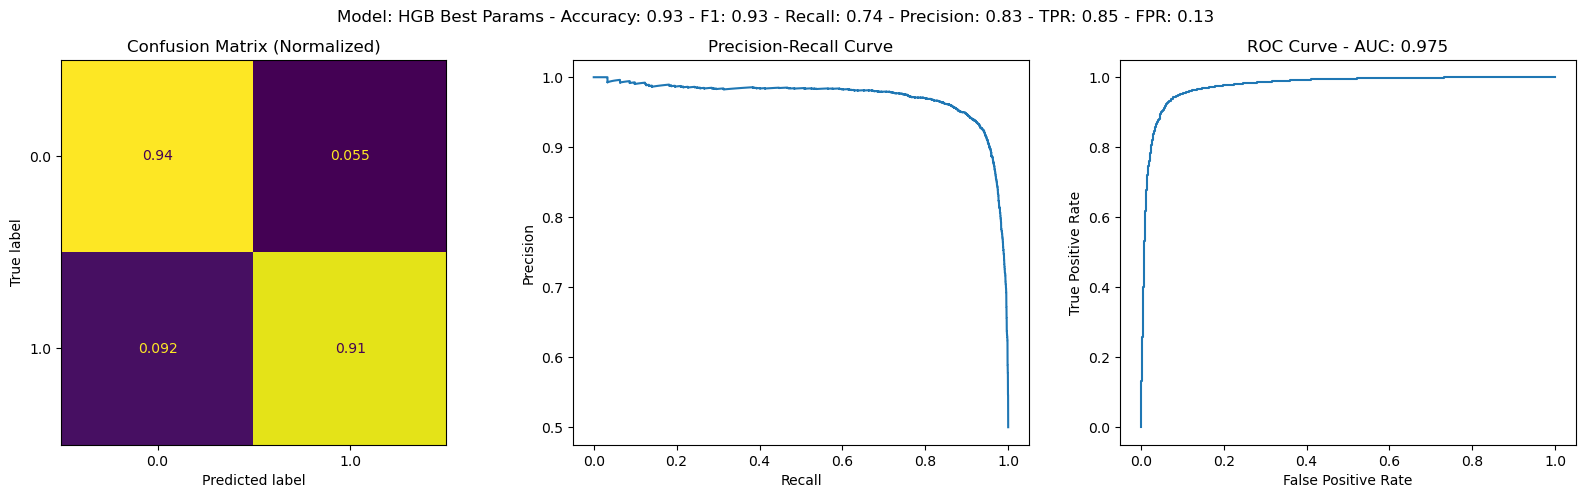

In [49]:
if best_params is None:
    best_params = {
        "learning_rate": 0.07068619051755831,
        "l2_regularization": 0.00022185517620643103,
        "max_iter": 260,
        "max_leaf_nodes": 80,
        "max_depth": 410,
        "max_bins": 127,
        "min_samples_leaf": 26,
        "early_stopping": True,
    }
model = make_pipeline(
    RobustScaler(unit_variance=True), HistGradientBoostingClassifier(**best_params)
)
s, c = get_scores(
    model,
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    display=True,
    name="HGB Best Params",
)
s

# Considerations

We can see that the final model has a good performance and that in the 93% of the cases the model is able to predict the correct class. In fact the ROC-AUC is 0.97/1. The precision and recall curve are also very good but in the context of medical diagnosis we would like to have a better recall. In our case, on average, the model is able to predict an infected cell with a 90% of probability. This is a good result but we could try to make some 'a posteriori' analysis to understand if we can improve the recall on the infected class.

1. > Try with altered classification threshold: consider the probability of the predicted class as a score and use a threshold to classify the cell as infected or not. We want to maximize the recall on the infected class without loosing too much precision on the healthy class.

Text(0.5, 1.0, 'Histogram of the predicted probabilities')

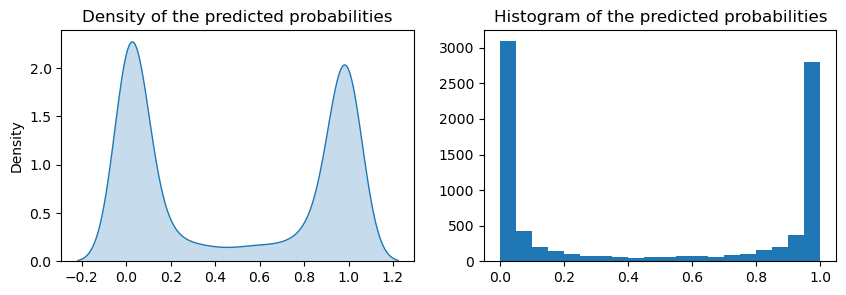

In [50]:
# Plot the density of the predicted probabilities
proba = model.predict_proba(X_test)
_, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(proba[:, 1], fill=True, ax=ax[0])
ax[0].set_title("Density of the predicted probabilities")
ax[1].hist(proba[:, 1], bins=20)
ax[1].set_title("Histogram of the predicted probabilities")

In this density plot we can see that we have much higher probability to make correct guesses, meaning that we have very few cases where the model has some uncertainty about the class of a cell. Also, looking at the histogram of probabilities we can see that our values are very close to 0 or 1, so the threshold should be very aggrressive to improve the recall.

Text(0.5, 1.0, 'Histogram for altered probabilities at max recall')

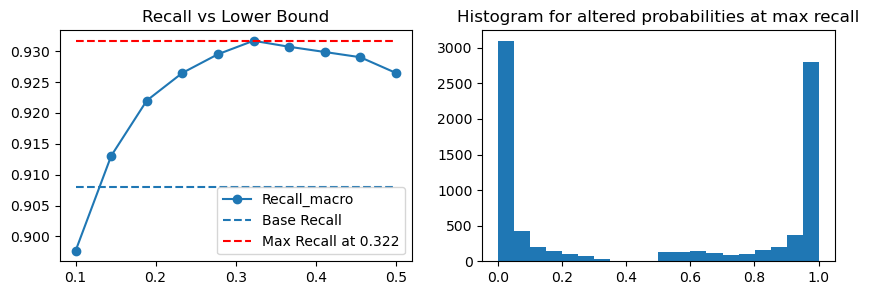

In [51]:
# try to plot recall score vs lower bound
# we are trying to alter every probability between 0.1 and 0.5
ub = 0.51
lb = np.linspace(0.1, 0.5, 10)
pred = proba[:, 1]
base_recall = recall_score(y_test, (pred > 0.5).astype(int))
recall = np.asarray(base_recall)
new_prob_list = np.zeros((len(lb), len(pred)))
# ! change the average params to see how it affects the recall score
average = "macro"
for bound in lb:
    new_prob = pred.copy()
    indexes = (pred >= bound) & (pred <= max(lb))
    new_prob[indexes] = 1 - pred[indexes]
    new_prob_list[np.where(lb == bound)[0][0]] = new_prob
    y_pred = (new_prob > 0.5).astype(int)
    recall = np.append(recall, recall_score(y_test, y_pred, average=average))
_, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(lb, recall[1:], "o-")
ax[0].hlines(base_recall, min(lb), max(lb), linestyles="dashed")
ax[0].hlines(max(recall), min(lb), max(lb), linestyles="dashed", colors="red")
ax[0].legend(
    [
        f"Recall_{average}",
        "Base Recall",
        f"Max Recall at {lb[np.argmax(recall[1:])]:.3f}",
    ]
)
ax[0].set_title("Recall vs Lower Bound")
ax[1].hist(new_prob_list[np.argmax(recall[1:])], bins=20)
ax[1].set_title("Histogram for altered probabilities at max recall")

Setting the threshold for the infected class lower than 0.5 lead to higher recall, but this means also that the precision will slowly decrease. Optimizing the threshold could help us to find a good trade-off

In [52]:
# Define objective function for Optuna
def best_threshold(trial, pred, pred_proba, average):
    # Define the lower bound of the threshold - the upper bound is 0.5
    lower_bound = trial.suggest_float("lower_bound", 0.1, 0.5, log=True)
    # get the indexes of the probabilities that are between the lower bound and 0.5
    indexes = (pred_proba[:, 1] >= lower_bound) & (pred_proba[:, 1] <= 0.5)
    # apply the threshold to the probabilities
    probs_t = pred_proba[:, 1].copy()
    # simply flip the probabilities when indexes are True
    probs_t[indexes] = 1 - probs_t[indexes]
    # map the probabilities to 0 or 1
    predictions = (probs_t > 0.5).astype(int)
    # calculate the recall score
    recall = recall_score(y_true=pred, y_pred=predictions, average=average)
    return recall


# define the study
recall_study = optuna.create_study(
    direction="maximize",
    study_name="recall",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(),
)
J = lambda trial: best_threshold(trial, y_test.values, proba, average)
recall_study.optimize(J, n_trials=150, gc_after_trial=True)
# optuna.visualization.matplotlib.plot_optimization_history(recall_study)
recall_study.best_params

[I 2023-04-02 23:27:01,853] A new study created in memory with name: recall
[I 2023-04-02 23:27:01,860] Trial 0 finished with value: 0.908684083212385 and parameters: {'lower_bound': 0.12832285745953664}. Best is trial 0 with value: 0.908684083212385.
[I 2023-04-02 23:27:01,938] Trial 1 finished with value: 0.9236816642477019 and parameters: {'lower_bound': 0.19931554636484883}. Best is trial 1 with value: 0.9236816642477019.
[I 2023-04-02 23:27:02,012] Trial 2 finished with value: 0.9046927914852443 and parameters: {'lower_bound': 0.11683860449411615}. Best is trial 1 with value: 0.9236816642477019.
[I 2023-04-02 23:27:02,086] Trial 3 finished with value: 0.9193275278180939 and parameters: {'lower_bound': 0.16964003856143772}. Best is trial 1 with value: 0.9236816642477019.
[I 2023-04-02 23:27:02,159] Trial 4 finished with value: 0.9282776971456217 and parameters: {'lower_bound': 0.25340680412138133}. Best is trial 4 with value: 0.9282776971456217.
[I 2023-04-02 23:27:02,231] Trial 5 

{'lower_bound': 0.31717145370596034}

The metrics respect to this threshold are:

Accuracy score: 0.932
Precision score: 0.924
Recall score: 0.941


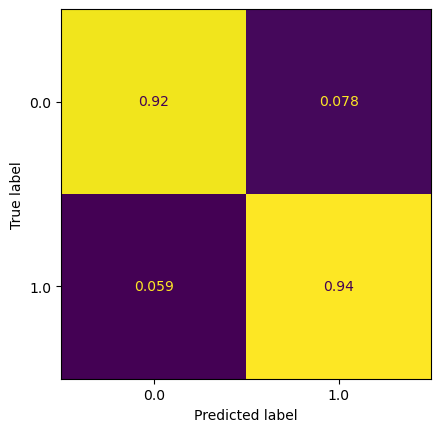

In [53]:
acc = accuracy_score(
    y_test, (proba[:, 1] > recall_study.best_params["lower_bound"]).astype(int)
)
print(f"Accuracy score: {acc:.3f}")
prec = precision_score(
    y_test, (proba[:, 1] > recall_study.best_params["lower_bound"]).astype(int)
)
print(f"Precision score: {prec:.3f}")
recall = recall_score(
    y_test, (proba[:, 1] > recall_study.best_params["lower_bound"]).astype(int)
)
print(f"Recall score: {recall:.3f}")
cm = confusion_matrix(
    y_test,
    (proba[:, 1] > recall_study.best_params["lower_bound"]).astype(int),
    normalize="true",
)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(colorbar=False)

2. > Alter class weights: we can try to alter the class weights to give more importance to the infected class. This will lead to a better recall on the infected class but it will also increase the false positive rate on the healthy class.

In [54]:
# Optimize the class weight
best_weight = None
# Define objective function to spot the best class weight
def best_class_weight(trial, X_train, y_train, params):
    weight_0 = trial.suggest_float("weight_0", 0.1, 0.5, log=True)
    class_weight = {0: weight_0, 1: 1 - weight_0}
    # define the model
    model = make_pipeline(
        RobustScaler(),
        HistGradientBoostingClassifier(**params, class_weight=class_weight),
    )
    # define the cross validation object
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    score = cross_val_score(
        model, X_train, y_train, cv=skf, scoring="recall_macro", n_jobs=-1
    )
    return score.mean()


# ! this takes a while to run
# define the study
# weight_study = optuna.create_study(direction='maximize', study_name='class_weight', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
# J = lambda trial: best_class_weight(trial, X_train_val, y_train_val, best_params)
# weight_study.optimize(J, n_trials=10, gc_after_trial=True)
# best_weight = weight_study.best_params

> Optimization Results:

![](../results/class_weight_opt.png)

,precision,recall,f1-score,support,AUC
0.0,0.922529,0.939042,0.930712,4134,NaN
1.0,0.937931,0.921142,0.929461,4134,NaN
accuracy,NaN,NaN,0.930092,8268,NaN
macro avg,0.93023,0.930092,0.930086,8268,NaN
weighted avg,0.93023,0.930092,0.930086,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.974856


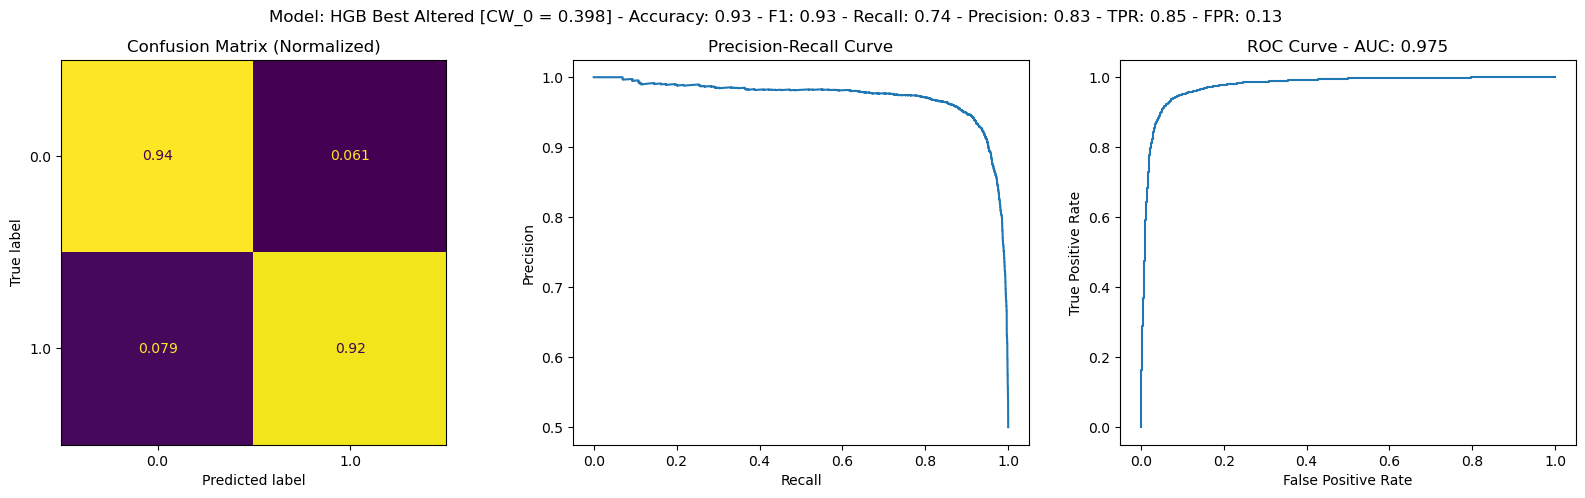

In [55]:
# Test the altered model
# check if the parameter is optimized in this run or not to save time
if best_weight is None:
    best_weight = 0.39781129987053776
altered_model = make_pipeline(
    RobustScaler(),
    HistGradientBoostingClassifier(
        **best_params, class_weight={0: best_weight, 1: 1 - best_weight}
    ),
)
s, c = get_scores(
    altered_model,
    X_train_val,
    y_train_val,
    X_test,
    y_test,
    display=True,
    name=f"HGB Best Altered [CW_0 = {best_weight:.3f}]",
)
s

Looking at the recall score for che infected class we can see a little improvement without loosing too much precision on the healthy class. The ROC-AUC is also very good. We could try to optimize the weights with a bigger number of trials but the score is so high that further improvement is not necessary and it will take a lot of time.

3. > Try to use diffent view of the dataset: Looking at the RGB channels separately we could find that the infection is more visible in one of the channels and use that channel to train the model.

To do this we will use a model that is able to make a good score but with lesser training time: the Stochastic Gradient Descent classifier.

In [56]:
# clean up the memory again
del (
    acc,
    average,
    ax,
    base_recall,
    best_params,
    best_weight,
    bound,
    cm,
    c,
    df,
    hgb,
    indexes,
    lb,
    new_prob,
    new_prob_list,
    prec,
    pred,
    proba,
    randint,
    recall,
    recall_study,
    robust_scale,
    root,
    s,
    std_scale,
    test_ratio,
    ub,
    X,
    X_train_val,
    y_train_val,
)
gc.collect()

<function gc.collect(generation=2)>

In [57]:
# Make dataset for each color channel
with concurrent.futures.ProcessPoolExecutor() as executor:
    r_u = np.asarray(list(executor.map(make_dataset, r_u_list)))
    r_p = np.asarray(list(executor.map(make_dataset, r_p_list)))
    g_u = np.asarray(list(executor.map(make_dataset, g_u_list)))
    g_p = np.asarray(list(executor.map(make_dataset, g_p_list)))
    b_u = np.asarray(list(executor.map(make_dataset, b_u_list)))
    b_p = np.asarray(list(executor.map(make_dataset, b_p_list)))
X_R = np.concatenate((r_u, r_p))
X_G = np.concatenate((g_u, g_p))
X_B = np.concatenate((b_u, b_p))
del(r_u, r_p, g_u, g_p, b_u, b_p, r_u_list, r_p_list, g_u_list, g_p_list, executor)
gc.collect()

0

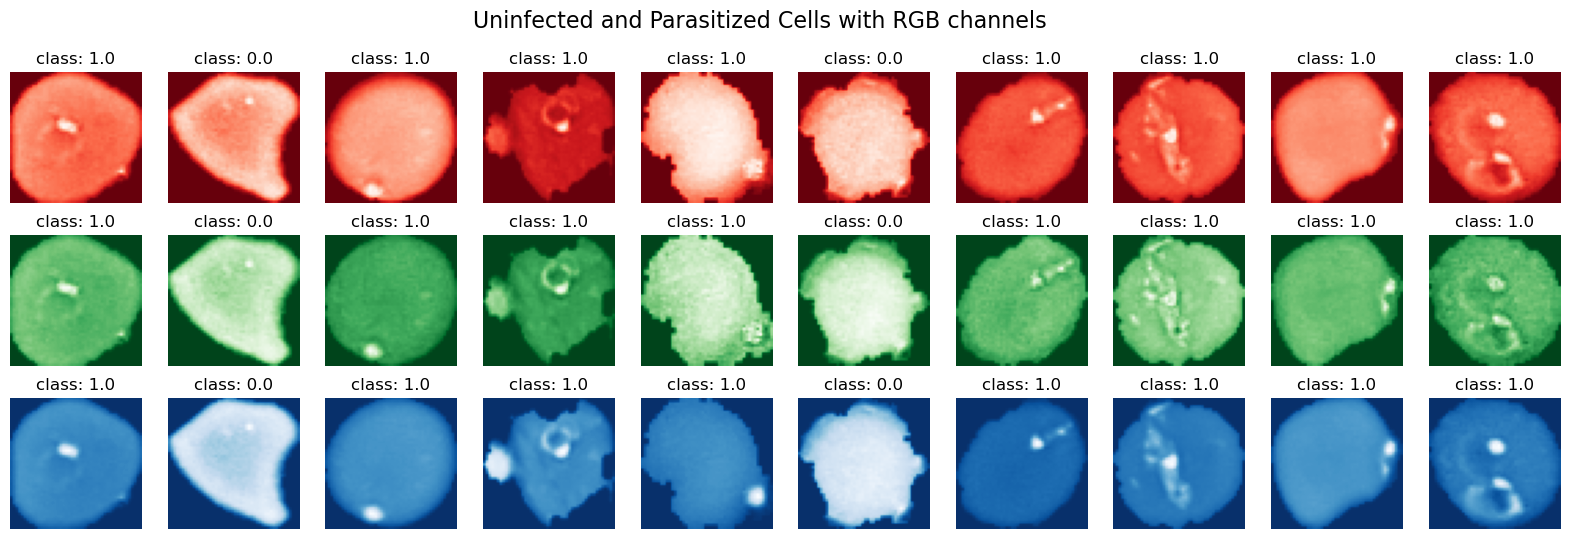

In [58]:
# make datasets and plot some samples
test_ratio = 0.3
df = pd.DataFrame(data=X_R, columns=range(np.shape(X_R)[1])).merge(
    pd.DataFrame(data=y, columns=["labels"]), left_index=True, right_index=True
)
X_R_train, X_R_test, y_R_train, y_R_test = train_test_split(
    df.drop("labels", axis=1),
    df["labels"],
    test_size=test_ratio,
    shuffle=True,
    stratify=y,
    random_state=42,
)
df = pd.DataFrame(data=X_G, columns=range(np.shape(X_G)[1])).merge(
    pd.DataFrame(data=y, columns=["labels"]), left_index=True, right_index=True
)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(
    df.drop("labels", axis=1),
    df["labels"],
    test_size=test_ratio,
    shuffle=True,
    stratify=y,
    random_state=42,
)
df = pd.DataFrame(data=X_B, columns=range(np.shape(X_B)[1])).merge(
    pd.DataFrame(data=y, columns=["labels"]), left_index=True, right_index=True
)
X_G_train, X_G_test, y_G_train, y_G_test = train_test_split(
    df.drop("labels", axis=1),
    df["labels"],
    test_size=test_ratio,
    shuffle=True,
    stratify=y,
    random_state=42,
)

fig, ax = plt.subplots(3, 10, figsize=(20, 6))
fig.suptitle("Uninfected and Parasitized Cells with RGB channels", fontsize=16)
for _ in df.index.values.tolist()[0:10] :
    ax[0, _].imshow(X_R_train.iloc[_].values.reshape(48, 48), cmap='Reds')
    ax[0,_].set_title(f"class: {y_R_train.iloc[_]}")
    ax[0,_].axis('off')
    ax[1, _].imshow(X_G_train.iloc[_].values.reshape(48,48), cmap='Greens')
    ax[1,_].set_title(f"class: {y_G_train.iloc[_]}")
    ax[1,_].axis('off')
    ax[2, _].imshow(X_B_train.iloc[_].values.reshape(48,48), cmap='Blues')
    ax[2,_].set_title(f"class: {y_B_train.iloc[_]}")
    ax[2,_].axis('off')

plt.show()

Make tests without any filters

In [59]:
# define the pipeline again
pipe  = make_pipeline(
    RobustScaler(),
    Nystroem(n_components=1000, n_jobs=-1),
    SGDClassifier(
        loss="modified_huber", penalty="elasticnet", max_iter=10000, n_jobs=-1
    )
)

,precision,recall,f1-score,support,AUC
0.0,0.700528,0.834059,0.761484,4134,NaN
1.0,0.794979,0.643445,0.71123,4134,NaN
accuracy,NaN,NaN,0.738752,8268,NaN
macro avg,0.747754,0.738752,0.736357,8268,NaN
weighted avg,0.747754,0.738752,0.736357,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.820472


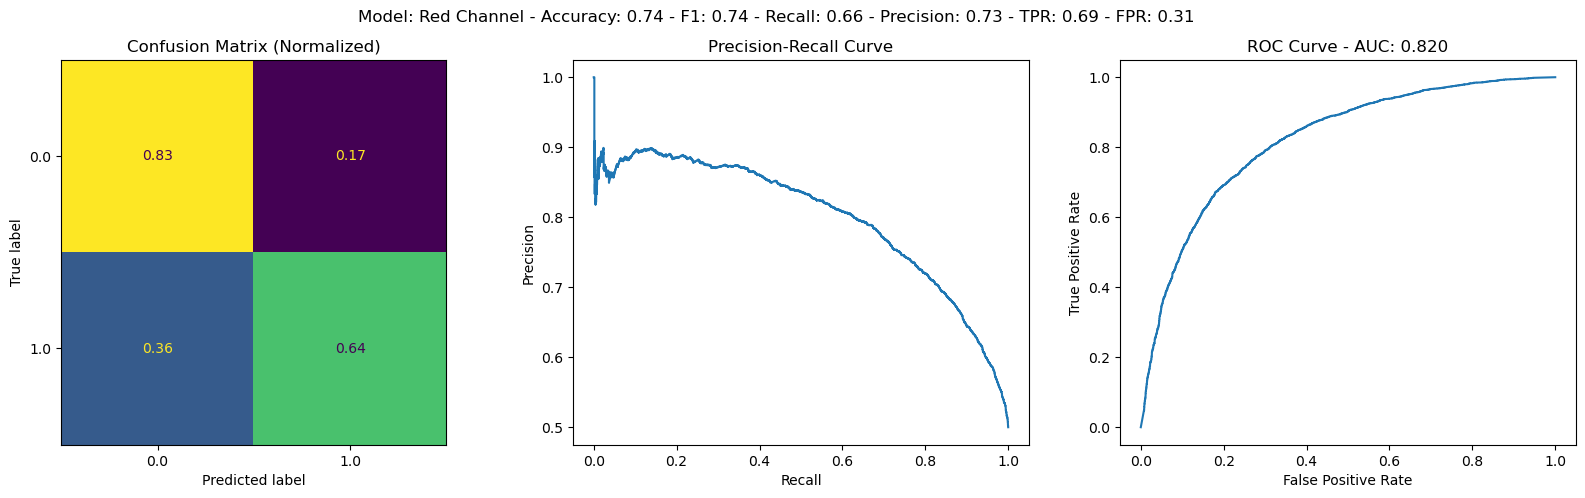

In [60]:
# Tests for Red channel
s_r, c_r = get_scores(pipe, X_R_train, y_R_train, X_R_test, y_R_test, display=True, name="Red Channel")
s_r

,precision,recall,f1-score,support,AUC
0.0,0.740171,0.837929,0.786022,4134,NaN
1.0,0.813266,0.705854,0.755763,4134,NaN
accuracy,NaN,NaN,0.771892,8268,NaN
macro avg,0.776719,0.771892,0.770892,8268,NaN
weighted avg,0.776719,0.771892,0.770892,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.85174


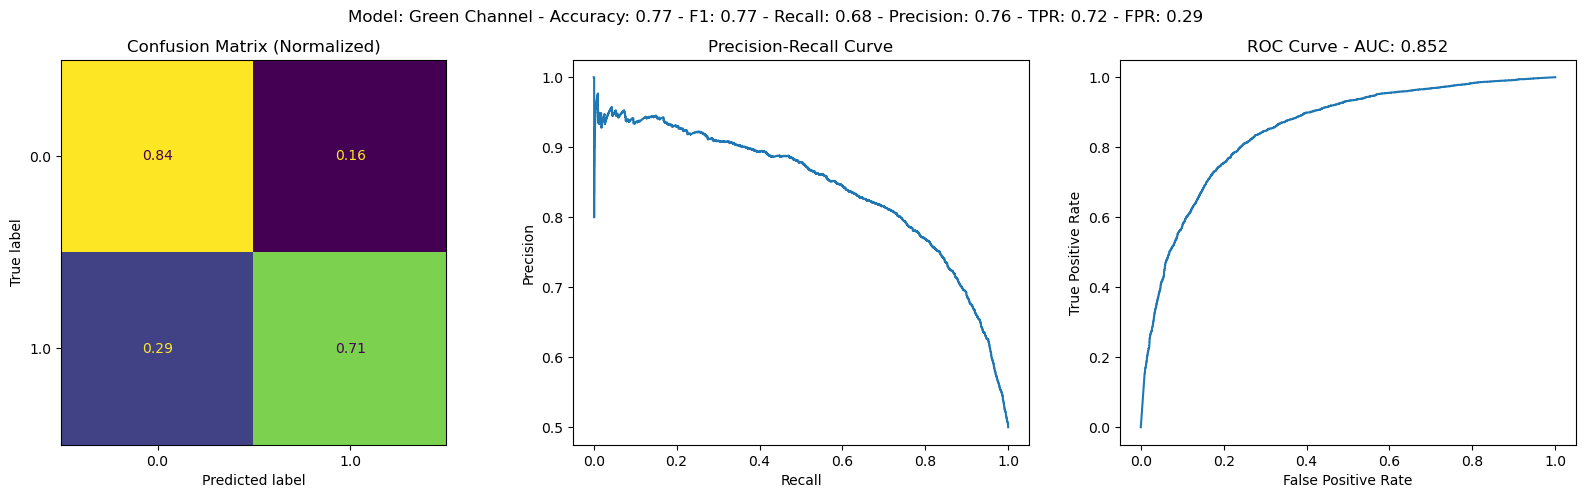

In [61]:
# Tests for Green channel
s_g, c_g = get_scores(pipe, X_G_train, y_G_train, X_G_test, y_G_test, display=True, name="Green Channel")
s_g

,precision,recall,f1-score,support,AUC
0.0,0.88321,0.894533,0.888835,4134,NaN
1.0,0.893163,0.881713,0.887401,4134,NaN
accuracy,NaN,NaN,0.888123,8268,NaN
macro avg,0.888187,0.888123,0.888118,8268,NaN
weighted avg,0.888187,0.888123,0.888118,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.942999


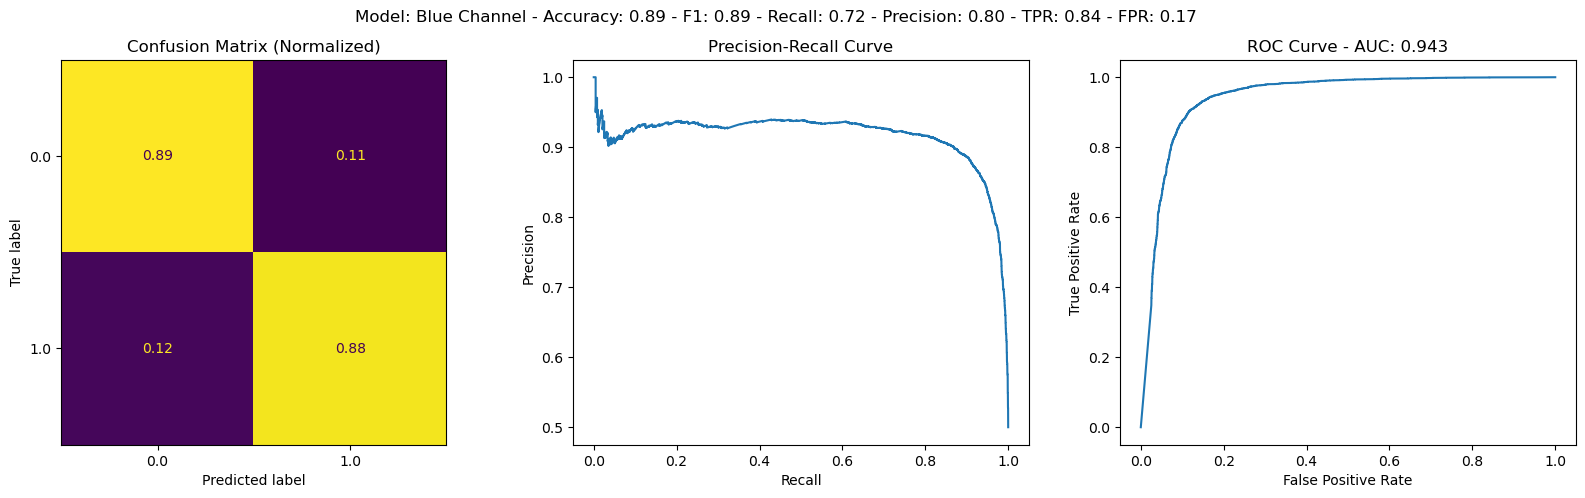

In [62]:
s_b, c_b = get_scores(pipe, X_B_train, y_B_train, X_B_test, y_B_test, display=True, name="Blue Channel")
s_b

It seems that the Stochastic Gradient Descent model is able to make good predictions with the Blue Dataset and their are better than the ones made with the grayscale dataset ([comparing the same model](#sgd_cell)). In the next step we will try to use the some filters to see if we can improve the scores.

In [63]:
# Define support functions for the filters
from skimage import exposure
from skimage.filters import gaussian, meijering, sato, hessian
from skimage.restoration import denoise_tv_chambolle

def contrast_strength(img):
    size = img.shape
    return exposure.rescale_intensity(img.reshape(size[0], size[1])).reshape(size[0]*size[1])

def denoise_tv(img):
    size = img.shape
    return denoise_tv_chambolle(img.reshape(size[0], size[1]), weight=0.1).reshape(size[0]*size[1])

def gaussian_blur(img):
    size = img.shape
    return gaussian(img.reshape(size[0], size[1]), sigma=1, truncate=2).reshape(size[0]*size[1])

def meijering_filter(img):
    size = img.shape
    return meijering(img.reshape(size[0], size[1]), range(1,5)).reshape(size[0]*size[1])

def sato_filter(img):
    size = img.shape
    return sato(img.reshape(size[0], size[1]), range(1,5)).reshape(size[0]*size[1])

def equalize_adaptive(img):
    size = img.shape
    kernel_size = np.array((size[0]//5, size[1]//5))
    clip_limit = 0.9
    return exposure.equalize_adapthist(img.reshape(size[0], size[1]), kernel_size=kernel_size, clip_limit=clip_limit).reshape(size[0]*size[1])

def make_filtered_dataset(args):
    """same as make_dataset but with a filter applied"""
    img, size, filter  = args['img'], args['size'], args['filter']
    img = resize(img, (size, size), anti_aliasing=True)
    img = remove_background(img)
    if filter == "contrast_strength":
        img = contrast_strength(img)
    elif filter == "denoise_tv":
        img = denoise_tv(img)
    elif filter == "gaussian":
        img = gaussian_blur(img)
    elif filter == "meijering":
        img = meijering_filter(img)
    elif filter == "sato":
        img = sato_filter(img)
    elif filter == "adaptive":
        img = equalize_adaptive(img)
    return np.asarray(img).flatten()

# Define support items for the filters
# size = 48
# b_list = b_u_list + b_p_list
# filters = ['contrast_strength', 'denoise_tv', 'gaussian', 'meijering', 'sato', 'adaptive']
# df_dict = {}
# args = list()

(-0.5, 47.5, 47.5, -0.5)

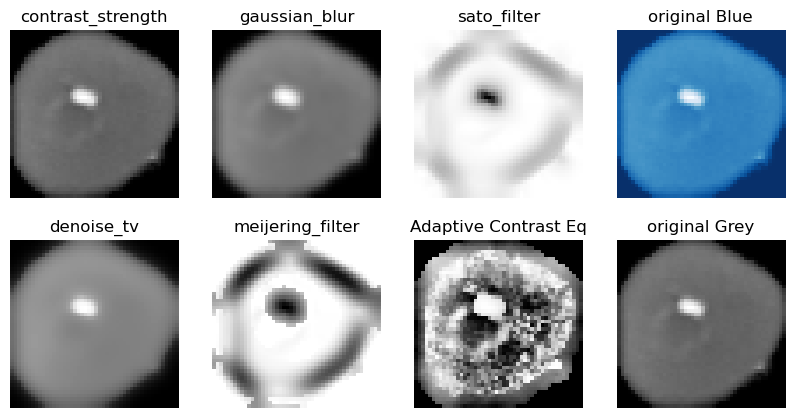

In [64]:
# Show what the filters do to an image
img = X_B_train.iloc[0].values.reshape(48,48)
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
ax[0,0].imshow(contrast_strength(img).reshape(48,48), cmap='Greys')
ax[0,0].set_title("contrast_strength")
ax[0,0].axis('off')
ax[0,1].imshow(gaussian_blur(img).reshape(48,48), cmap='Greys')
ax[0,1].set_title("gaussian_blur")
ax[0,1].axis('off')
ax[1,0].imshow(denoise_tv(img).reshape(48,48), cmap='Greys')
ax[1,0].set_title("denoise_tv")
ax[1,0].axis('off')
ax[1,1].imshow(meijering_filter(img).reshape(48,48), cmap='Greys')
ax[1,1].set_title("meijering_filter")
ax[1,1].axis('off')
ax[0,2].imshow(sato_filter(img).reshape(48,48), cmap='Greys')
ax[0,2].set_title("sato_filter")
ax[0,2].axis('off')
ax[1,2].imshow(equalize_adaptive(img).reshape(48,48), cmap='Greys')
ax[1,2].set_title("Adaptive Contrast Eq")
ax[1,2].axis('off')
ax[0,3].imshow(img.reshape(48,48), cmap='Blues')
ax[0,3].set_title("original Blue")
ax[0,3].axis('off')
ax[1,3].imshow(img.reshape(48,48), cmap='Greys')
ax[1,3].set_title("original Grey")
ax[1,3].axis('off')


In [65]:
# f = "contrast_strength"
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     arg = [{'img': img, 'size': size, 'filter': f} for img in b_list]
#     filtered_set = np.asarray(list(executor.map(make_filtered_dataset, arg)))
# df_dict[f] = pd.DataFrame(filtered_set)
# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(df_dict['contrast_strength'], np.asarray(y).ravel(), test_size=0.3, random_state=42, stratify=y)
# s_adjust, _ = get_scores(pipe, X_b_train, y_b_train, X_b_test, y_b_test, display=True, name="Contrast Strength")
# s_adjust


In [66]:
# f = "denoise_tv"
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     arg = [{'img': img, 'size': size, 'filter': f} for img in b_list]
#     filtered_set = np.asarray(list(executor.map(make_filtered_dataset, arg)))
# df_dict[f] = pd.DataFrame(filtered_set)
# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(df_dict['denoise_tv'], np.asarray(y).ravel(), test_size=0.3, random_state=42, stratify=y)
# s_adjust, _ = get_scores(pipe, X_b_train, y_b_train, X_b_test, y_b_test, display=True, name="Denoise TV")
# s_adjust


In [67]:
# f = "gaussian"
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     arg = [{'img': img, 'size': size, 'filter': f} for img in b_list]
#     filtered_set = np.asarray(list(executor.map(make_filtered_dataset, arg)))
# df_dict[f] = pd.DataFrame(filtered_set)
# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(df_dict['gaussian'], np.asarray(y).ravel(), test_size=0.3, random_state=42, stratify=y)
# s_adjust, _ = get_scores(pipe, X_b_train, y_b_train, X_b_test, y_b_test, display=True, name="gaussian blur")
# s_adjust

In [68]:
# f = "meijering"
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     arg = [{'img': img, 'size': size, 'filter': f} for img in b_list]
#     filtered_set = np.asarray(list(executor.map(make_filtered_dataset, arg)))
# df_dict[f] = pd.DataFrame(filtered_set)
# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(df_dict['meijering'], np.asarray(y).ravel(), test_size=0.3, random_state=42, stratify=y)
# s_adjust, _ = get_scores(pipe, X_b_train, y_b_train, X_b_test, y_b_test, display=True, name="Meijering")
# s_adjust

In [69]:
# f = "sato"
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     arg = [{'img': img, 'size': size, 'filter': f} for img in b_list]
#     filtered_set = np.asarray(list(executor.map(make_filtered_dataset, arg)))
# df_dict[f] = pd.DataFrame(filtered_set)
# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(df_dict['sato'], np.asarray(y).ravel(), test_size=0.3, random_state=42, stratify=y)
# s_adjust, _ = get_scores(pipe, X_b_train, y_b_train, X_b_test, y_b_test, display=True, name="Sato")
# s_adjust

In [70]:
# f = "adaptive"
# with concurrent.futures.ProcessPoolExecutor() as executor:
    # arg = [{'img': img, 'size': size, 'filter': f} for img in b_list]
    # filtered_set = np.asarray(list(executor.map(make_filtered_dataset, arg)))
# df_dict[f] = pd.DataFrame(filtered_set)
# X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(df_dict['adaptive'], np.asarray(y).ravel(), test_size=0.3, random_state=42, stratify=y)
# s_adjust, _ = get_scores(pipe, X_b_train, y_b_train, X_b_test, y_b_test, display=True, name="Adaptive Contrast Eq")
# s_adjust

For the sake of time we will just present the results of the tests with the filters:
<img src="../results/contrast_strength.png" width=1024>
<img src="../results/denoise_tv.png" width=1024>
<img src="../results/gaussian_blur.png" width=1024>
<img src="../results/meijering.png" width=1024>
<img src="../results/sato.png" width=1024>
<img src="../results/adaptive_contrast.png" width=1024>

We saw that filters don't improve the score but as last test we can try to see what happen if we use the blue channel dataset to train the HGB model we found in the previous phase. To get comparable results we will use the pipeline defined before the optimization phase.

,precision,recall,f1-score,support,AUC
0.0,0.898861,0.954523,0.925856,4134,NaN
1.0,0.951521,0.892598,0.921118,4134,NaN
accuracy,NaN,NaN,0.923561,8268,NaN
macro avg,0.925191,0.923561,0.923487,8268,NaN
weighted avg,0.925191,0.923561,0.923487,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.975712


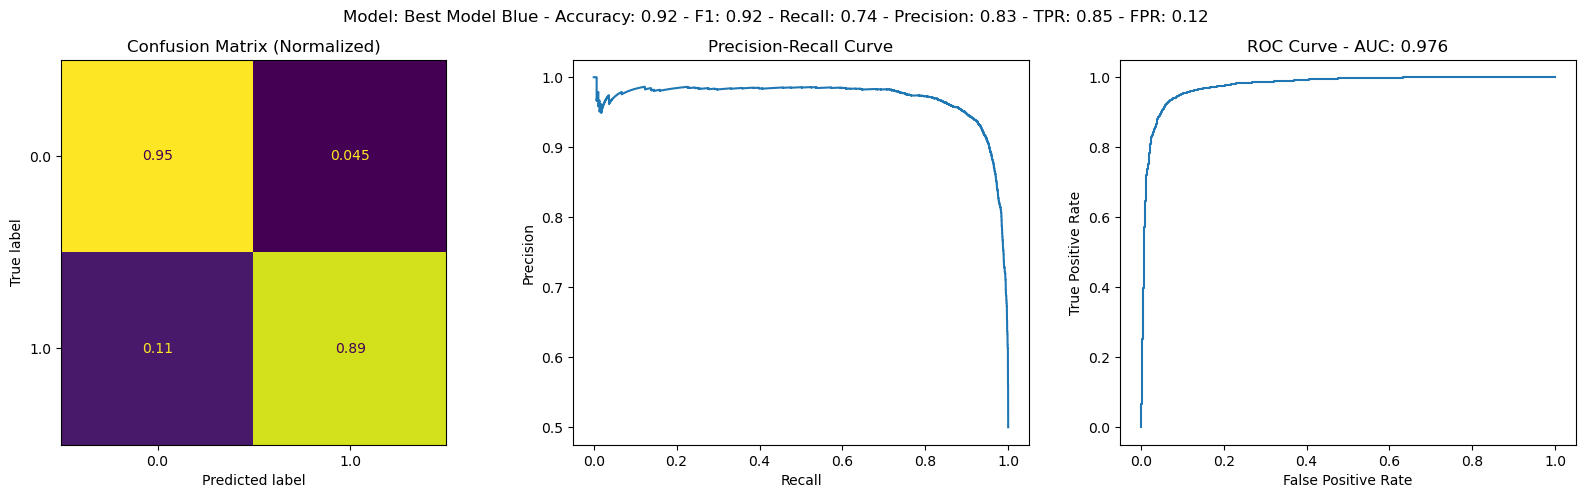

In [75]:
# Test the HGB model on the blue dataset
score_blue, _ = get_scores(robust_pipe_HGB, X_B_train, y_B_train, X_B_test, y_B_test, display=True, name="HGB Blue")
score_blue

The overall score seems to be the same but the recall is higher, so we can say that the blue channel dataset is better than the grayscale one. Probably the infection is more visible in the blue channel and this is the reason why the model is able to make better predictions. We could go further and try to use the blue channel to achieve better results with optimizations and altering the class weights but we will stop here.